In [1]:
# Import necessary libraries
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from scipy import signal, optimize
import math
import random

In [3]:
class Pixel():
    '''
    Class for keeping pixel cooridinate
    '''

    def __init__(self, kp):
        self.x = int(kp.pt[0])
        self.y = int(kp.pt[1])
        self.point = (self.x, self.y)

    def __repr__(self):
        return f'({self.x}, {self.y})'

    def adjust_width(self, width):
        x = self.x + width
        return (x, self.y)

In [82]:
class Image():
    ''' 
    Class for store images and related parameters.
    '''

    FILEPATH = 'ece661_pics\\hw5_image\\'
    NCC_WINDOW_SIZE = 10 # 21 x 21 pixel

    def __init__(self, name):
        self.name = name
        self.load_images()
        self.keypoints = None
        

    def load_images(self):
        self.image = cv.imread(self.FILEPATH + self.name + '.jpg')

    def show_image(self):
        plt.imshow(cv.cvtColor(self.image, cv.COLOR_BGR2RGB))

    def extract_feature(self):
        '''
            Extract the features from image using SIFT and the window around the features.
        '''
        if self.keypoints is not None:
            return self.keypoints, self.windows
        
        gray_image = cv.cvtColor(self.image, cv.COLOR_BGR2GRAY)
        # Extract features with SIFT
        features = cv.xfeatures2d.SIFT_create()
        kps, des = features.detectAndCompute(gray_image, None)

        width = self.NCC_WINDOW_SIZE
        # List of keypoint
        self.keypoints = []
        # Filter out keypoints that are close to the edge
        for kp in kps:
            if  width <= kp.pt[0] < gray_image.shape[1] - width and \
                width <= kp.pt[1] < gray_image.shape[0] - width:
                self.keypoints.append(Pixel(kp))
        
        # Make an array size_of_window x number_of_keypoints. Started with 0 vector column
        windows = np.zeros(((width*2 + 1) ** 2, 1)).astype(int)
        for keypoint in self.keypoints:
            # Extract NCC window around the keypoing
            window = gray_image[keypoint.y - width : keypoint.y + width+1, keypoint.x - width : keypoint.x + width+1]
            mean = np.mean(window)
            # Adjust with its mean before append to final array
            window = window - mean
            windows = np.append(windows, window.reshape(window.size, 1), axis=1)
        
        # Remove 0 vector column
        self.windows = np.delete(windows, 0, axis=1)

        return self.keypoints, self.windows

    def mark_keypoints(self):
        '''
            Mark the feature on the image
        '''
        if self.keypoints is None:
            self.extract_feature()
            
        radius = 2
        thickness = 1
        color = (0, 0, 255)
        image = self.image.copy()
        for keypoint in self.keypoints:
            cv.circle(image, keypoint.point, radius, color, thickness)
        plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
        savename = f'{self.FILEPATH}{self.name}_keypoints.png'
        cv.imwrite(savename, image.astype(np.int))


img1 = Image('image1')
img2 = Image('image2')
img3 = Image('image3')
img4 = Image('image4')
img5 = Image('image5')

In [84]:
class ImagePair():
    '''
        Class for finding correspondences of pair of images
    '''
    NUMBER_PAIR = 250
    FILEPATH = 'ece661_pics\\hw5_image\\'

    def __init__(self, name, imgA, imgB):
        self.name = name
        self.imgA = imgA
        self.imgB = imgB
        self.image = cv.hconcat([self.imgA.image, self.imgB.image])
        self.pairs = None
    
    def show_image(self):
        plt.imshow(cv.cvtColor(self.image, cv.COLOR_BGR2RGB))

    def ncc_matching(self):
        '''
            find the pair of feature base on NCC. 
            Limit number of pair to the class constant.
        '''
        if self.pairs is not None:
            return self.pairs
        
        self.imgA.extract_feature()
        self.imgB.extract_feature()
        self.pairs = []
        
        # Array of NCC. Size is number_of_keypointA x Size is number_of_keypointB
        numerator  = np.dot(self.imgA.windows.T, self.imgB.windows)
        windowA_sq = self.imgA.windows * self.imgA.windows
        windowB_sq = self.imgB.windows * self.imgB.windows
        windowA_sumsq = np.sum(windowA_sq, axis=0).reshape((windowA_sq.shape[1], 1))
        windowB_sumsq = np.sum(windowB_sq, axis=0).reshape((windowB_sq.shape[1], 1))
        denominator = np.sqrt(np.dot(windowA_sumsq, windowB_sumsq.T))
        ncc = numerator/denominator

        # Keep highest value of NCC pairs upto the number define in class constant. 
        ncc_highest = np.amax(ncc, axis=1)
        ncc_highest_idx = np.argmax(ncc, axis=1)
        sorted_inx = np.argsort(ncc_highest)
        sorted_inx = sorted_inx[-self.NUMBER_PAIR:]
        for inx in sorted_inx:
            kpA = self.imgA.keypoints[inx]
            kpB = self.imgB.keypoints[ncc_highest_idx[inx]]
            pair = (kpA, kpB)
            self.pairs.append(pair)
        
        return self.pairs

    def mark_pairs(self):
        '''
            Mark correspondences
        '''

        if self.pairs is None:
            self.ncc_matching()

        radius = 2
        thickness = 1
        color = (0, 0, 255)
        image = self.image.copy()
        w = self.imgA.image.shape[1]
        for pair in self.pairs:
            pointA = pair[0].point
            pointB = pair[1].adjust_width(w)
            cv.circle(image, pointA, radius, color, thickness)
            cv.circle(image, pointB, radius, color, thickness)
            cv.line(image, pointA, pointB, color, thickness)

        plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
        savename = f'{self.FILEPATH}{self.name}_NCC.png'
        cv.imwrite(savename, image.astype(np.int))


pair12 = ImagePair('pair12', img1, img2)
pair23 = ImagePair('pair23', img2, img3)
pair34 = ImagePair('pair34', img3, img4)
pair45 = ImagePair('pair45', img4, img5)

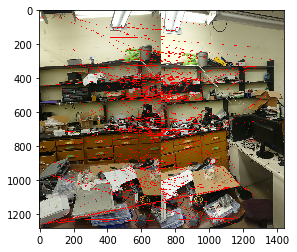

In [85]:
pair12.mark_pairs()
pair23.mark_pairs()
pair34.mark_pairs()
pair45.mark_pairs()

In [7]:
class Ransac():
    '''
        Class for performing RANSAC algorithm
    '''

    def __init__(self, n, p, e, d):
        self.n = n
        self.p = p
        self.e = e
        self.d = d
        self.num_trial = int(np.log(1 - p) / np.log(1 - (1-e)**n))

    def compute_homography(self, pairs):
        '''
            Compute homography from input correspondences
        '''
        # Forming system of linear equation AH = b
        A = np.zeros((1, 8)) # Create first row with 0
        b = np.array([])

        for pair in pairs:
            X = pair[0] # X
            X_dash = pair[1] # X'

            a = np.array([X.x, X.y, 1, 0, 0, 0, -X.x * X_dash.x, -X.y * X_dash.x]).reshape((1, 8))
            A = np.append(A, a, axis=0)
            a = np.array([0, 0, 0, X.x, X.y, 1, -X.x * X_dash.y, -X.y * X_dash.y]).reshape((1, 8))
            A = np.append(A, a, axis=0)
            b = np.append(b, [X_dash.x, X_dash.y])

        A = np.delete(A, 0, axis=0) # Remove the first row
        b = b.reshape((-1, 1))

        ATA_inv = np.linalg.inv(np.dot(A.T, A))
        H = np.dot(ATA_inv, np.dot(A.T, b))
        H = np.append(H, [1]).reshape((3, 3))

        return H

    def get_homography(self, image_pair):
        '''
            Get the best homography by RANSAC algorithm
        '''

        # Put all correspondance into 3 x num_of_pairs of X and X'
        X = np.zeros((3, 1)) # X
        X_dash = np.zeros((3, 1)) # X'
        for pair in image_pair.pairs:
            X = np.append(X, [[pair[0].x], [pair[0].y], [1]], axis=1)
            X_dash = np.append(X_dash, [[pair[1].x], [pair[1].y], [1]], axis=1)
        X = np.delete(X, 0, axis=1)
        X_dash = np.delete(X_dash, 0, axis=1)
  
        num_pair = len(image_pair.pairs)
        M = int(num_pair * (1 - self.e))

        H_best = None
        inlier = None
        max_inlier = 0
        
        for i in range(self.num_trial):
            # Sample correspondences then compute homography from the samples
            sample = random.sample(image_pair.pairs, self.n)
            H = self.compute_homography(sample)
            # Evaluate homography
            HX = np.matmul(H, X)
            HX = HX / HX[2, :]
            # Vector of displacement from X' and HX
            error = np.sum((HX - X_dash)**2, axis=0)
            # Find the index of inlier
            idx = np.argwhere(error < self.d**2).ravel()
            if len(idx) > max_inlier:
                inlier = [image_pair.pairs[i] for i in idx]
                H_best = H
                max_inlier = len(idx)
        
        return H_best, inlier

    def mark_inliers(self, image_pair, inliers=None):
        if inliers is None:
            [H, inliers] = self.get_homography(image_pair)
        
        radius = 2
        thickness = 1
        color = (0, 255, 0)
        image = image_pair.image.copy()
        w = image_pair.imgA.image.shape[1]
        for inlier in inliers:
            pointA = inlier[0].point
            pointB = inlier[1].adjust_width(w)
            cv.circle(image, pointA, radius, color, thickness)
            cv.circle(image, pointB, radius, color, thickness)
            cv.line(image, pointA, pointB, color, thickness)

        plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
        savename = f'{image_pair.FILEPATH}{image_pair.name}_inlier.png'
        cv.imwrite(savename, image.astype(np.int))


ransac = Ransac(6, 0.99, 0.5, 3)

[((553, 641), (337, 636)), ((540, 936), (315, 923)), ((540, 936), (315, 923)), ((617, 828), (391, 810)), ((444, 888), (224, 888)), ((416, 832), (195, 834)), ((497, 855), (278, 848)), ((404, 1000), (180, 1005)), ((500, 859), (280, 852)), ((412, 858), (191, 861)), ((578, 644), (360, 638)), ((578, 644), (360, 638)), ((488, 709), (270, 707)), ((441, 942), (216, 942)), ((580, 569), (361, 569)), ((580, 569), (361, 569)), ((433, 782), (214, 782)), ((410, 833), (189, 836)), ((517, 726), (298, 721)), ((536, 934), (311, 922)), ((613, 600), (390, 595)), ((613, 600), (390, 595)), ((505, 728), (285, 723)), ((353, 805), (129, 814)), ((482, 859), (262, 855)), ((488, 731), (269, 727)), ((488, 731), (269, 727)), ((346, 745), (125, 753)), ((277, 801), (47, 817)), ((360, 789), (137, 797)), ((360, 789), (137, 797)), ((449, 938), (225, 937)), ((584, 576), (363, 573)), ((584, 576), (363, 573)), ((344, 749), (122, 757)), ((543, 1194), (316, 1183)), ((602, 794), (379, 779)), ((285, 799), (57, 815)), ((348, 85

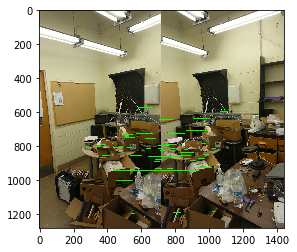

In [51]:
[H12, inliers12] = ransac.get_homography(pair12)
print(inliers12)
ransac.mark_inliers(pair12, inliers12)

[((701, 650), (405, 648)), ((607, 780), (328, 775)), ((607, 780), (328, 775)), ((481, 630), (209, 641)), ((481, 630), (209, 641)), ((484, 629), (212, 640)), ((484, 629), (212, 640)), ((627, 617), (344, 622)), ((323, 514), (37, 528)), ((577, 772), (301, 771)), ((601, 673), (323, 676)), ((556, 698), (281, 702)), ((546, 680), (271, 685)), ((546, 680), (271, 685)), ((546, 680), (271, 685)), ((546, 680), (271, 685)), ((411, 567), (138, 581)), ((411, 567), (138, 581)), ((658, 581), (371, 587)), ((658, 581), (371, 587)), ((565, 700), (289, 703)), ((344, 662), (62, 684)), ((531, 529), (255, 541)), ((531, 529), (255, 541)), ((351, 585), (71, 602)), ((533, 712), (259, 717)), ((547, 11), (275, 32)), ((400, 561), (126, 575)), ((447, 658), (173, 671)), ((697, 732), (402, 722)), ((503, 642), (230, 652)), ((520, 675), (248, 682)), ((669, 708), (379, 702)), ((518, 709), (246, 716)), ((569, 601), (293, 609)), ((519, 675), (247, 683)), ((449, 536), (175, 549)), ((421, 539), (146, 552)), ((335, 834), (50

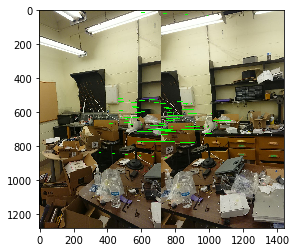

In [52]:
[H23, inliers23] = ransac.get_homography(pair23)
print(inliers23)
ransac.mark_inliers(pair23, inliers23)

[((471, 483), (175, 492)), ((474, 768), (184, 778)), ((447, 712), (156, 724)), ((447, 712), (156, 724)), ((489, 676), (200, 684)), ((489, 676), (200, 684)), ((476, 482), (180, 491)), ((439, 459), (140, 467)), ((439, 459), (140, 467)), ((469, 721), (179, 731)), ((475, 496), (181, 505)), ((544, 884), (257, 884)), ((542, 782), (252, 784)), ((433, 506), (138, 515)), ((477, 511), (183, 520)), ((402, 637), (108, 649)), ((402, 637), (108, 649)), ((449, 799), (161, 812)), ((643, 713), (342, 709)), ((527, 481), (231, 491)), ((670, 785), (366, 774)), ((612, 722), (314, 720)), ((706, 366), (383, 388)), ((706, 366), (383, 388)), ((411, 438), (109, 443)), ((394, 531), (97, 540)), ((642, 717), (341, 713)), ((494, 495), (199, 504)), ((460, 722), (169, 733)), ((419, 680), (126, 694)), ((419, 680), (126, 694)), ((435, 656), (144, 668)), ((406, 642), (113, 655)), ((476, 471), (179, 480)), ((570, 461), (270, 472)), ((500, 465), (203, 474)), ((607, 725), (310, 723)), ((496, 484), (200, 493)), ((508, 483),

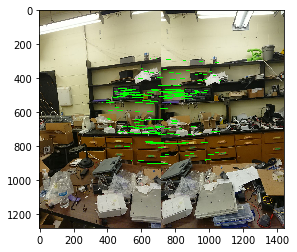

In [10]:
[H34, inliers34] = ransac.get_homography(pair34)
print(inliers34)
ransac.mark_inliers(pair34, inliers34)

[((602, 387), (229, 415)), ((602, 387), (229, 415)), ((580, 256), (199, 287)), ((495, 474), (133, 495)), ((588, 238), (205, 270)), ((473, 289), (93, 307)), ((596, 504), (235, 527)), ((568, 634), (219, 651)), ((636, 499), (272, 522)), ((594, 251), (212, 283)), ((594, 251), (212, 283)), ((594, 251), (212, 283)), ((580, 372), (210, 399)), ((410, 484), (39, 503)), ((414, 518), (48, 538)), ((543, 392), (173, 415)), ((598, 458), (232, 482)), ((673, 246), (284, 287)), ((532, 285), (154, 310)), ((531, 640), (182, 659)), ((514, 630), (166, 651)), ((514, 630), (166, 651)), ((555, 275), (175, 303)), ((562, 392), (190, 417)), ((471, 405), (100, 424)), ((431, 304), (47, 319)), ((548, 629), (199, 648)), ((548, 629), (199, 648)), ((585, 232), (202, 264)), ((585, 232), (202, 264)), ((521, 463), (157, 484)), ((604, 383), (231, 411)), ((604, 383), (231, 411)), ((604, 383), (231, 411)), ((476, 650), (125, 673)), ((476, 650), (125, 673)), ((420, 422), (49, 438)), ((459, 408), (86, 426)), ((559, 490), (198

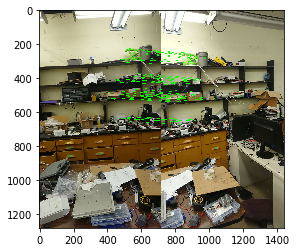

In [11]:
[H45, inliers45] = ransac.get_homography(pair45)
print(inliers45)
ransac.mark_inliers(pair45, inliers45)

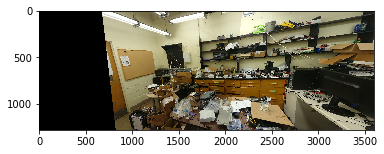

In [16]:
def panorama(H12, H23, H34, H45, img1, img2, img3, img4, img5, name):
    ''' 
        Generate panorama picture from 5 images
    '''
    filepath = 'ece661_pics\\hw5_image\\'

    img_all = [img1, img2, img3, img4, img5]

    # Compute necesarry homography
    H13 = np.matmul(H23, H12)
    H43 = np.linalg.inv(H34)
    H53 = np.matmul(H43, np.linalg.inv(H45))
    H3 = np.eye(3)

    # Calculate offset reference to image 3 (middle image)
    tx = img1.image.shape[1] + img2.image.shape[1]
    ty = 0
    H_translate = np.array([[1, 0, tx], [0, 1, ty], [0, 0, 1]])
    H_all  = [H13, H23, H3, H43, H53]
    for i, H in enumerate(H_all):
        H_all[i] = np.matmul(H_translate, H)
    
    # Create the canvas for final output
    height = 0
    width = 0
    for img in img_all:
        height = max(height, img.image.shape[0])
        width = width + img.image.shape[1]

    canvas = np.zeros((height, width, 3), np.uint8)

    # Create all pexels in final canvas. Stack into n x 3 array
    XX, YY = np.meshgrid(np.arange(0, width, 1), np.arange(0, height, 1))
    canvas_points = np.vstack((XX.ravel(), YY.ravel())).T
    canvas_points = np.append(canvas_points, np.ones((canvas_points.shape[0], 1)), axis=1).astype(np.int)

    for i, H in enumerate(H_all):
        img = img_all[i].image
        h, w, d = img.shape
        H_inv = np.linalg.inv(H)

        # Apply homography
        transfrom_points = np.dot(H_inv, canvas_points.T)
        transfrom_points = transfrom_points / transfrom_points[2, :]
        transfrom_points = transfrom_points.T

        # Filter out-of-bound
        valid_low_x = 0 <= transfrom_points[:, 0]
        valid_low_y = 0 <= transfrom_points[:, 1]
        valid_high_x = transfrom_points[:, 0] < w-1
        valid_high_y = transfrom_points[:, 1] < h-1
        valid_points = valid_low_x * valid_low_y * valid_high_x * valid_high_y
        valid_points_idx = np.argwhere(valid_points == True).ravel()

        # Mapping image
        for index in valid_points_idx:
            transfrom_point = np.round(transfrom_points[index]).astype(np.int)
            canvas_point = canvas_points[index]
            canvas[canvas_point[1]][canvas_point[0]][:] = img[transfrom_point[1]][transfrom_point[0]][:]

    plt.imshow(cv.cvtColor(canvas, cv.COLOR_BGR2RGB))
    savename = f'{filepath}{name}.png'
    cv.imwrite(savename, canvas)

panorama(H12, H23, H34, H45, img1, img2, img3, img4, img5, 'no_LM')

In [80]:
def refine_homography(H, pairs):
    '''
        Method for refining homography matrix with LM algorithm.
    '''

    def objective_func(H, pairs):
        ''' 
            ||X' - f(H)|| (num_of_inlier x 1 vector)
        '''
        X_dash = np.array([])
        F = np.array([])
        for pair in pairs:
            X = pair[0]
            denominator = X.x*H[6] + X.y*H[7] + H[8]
            F = np.append(F, (X.x*H[0] + X.y*H[1] + H[2]) / denominator) # F1
            F = np.append(F, (X.x*H[3] + X.y*H[4] + H[5]) / denominator) # F2
            X_dash = np.append(X_dash, [pair[1].x, pair[1].y])
            
        return X_dash - F

    def jacobian(H, pairs):
        '''
            Jacobian num_of_inlier x 9 matrix
        '''
        F = np.zeros((1, 9))
        for pair in pairs:
            X = pair[0]
            denominator = X.x*H[6] + X.y*H[7] + H[8]
            # Jacobian of F1
            delta_f = np.array([X.x / denominator,
                                X.y / denominator,
                                1 / denominator,
                                0,
                                0,
                                0,
                                (-X.x * (X.x*H[0] + X.y*H[1] + H[2])) / (denominator**2),
                                (-X.y * (X.x*H[0] + X.y*H[1] + H[2])) / (denominator**2),
                                (-1 * (X.x*H[0] + X.y*H[1] + H[2])) / (denominator**2)]).reshape((1, 9))
            F = np.append(F, delta_f, axis=0)
            # Jacobian of F2
            delta_f = np.array([0,
                                0,
                                1,
                                X.x / denominator,
                                X.y / denominator,
                                1 / denominator,
                                (-X.x * (X.x*H[3] + X.y*H[4] + H[5])) / (denominator**2),
                                (-X.y * (X.x*H[3] + X.y*H[4] + H[5])) / (denominator**2),
                                (-1 * (X.x*H[3] + X.y*H[4] + H[5])) / (denominator**2)]).reshape((1, 9))
            F = np.append(F, delta_f, axis=0)
        F = np.delete(F, 0, axis=0)

        # Jacobian of cost function equal to - Jacobian of F
        return -F

    H = H.ravel()
    sol = optimize.root(fun=objective_func, x0=H, args=pairs, jac=jacobian, method='lm')
    H_refined = sol.x
    H_refined = H_refined / H_refined[8]
    
    return H_refined.reshape((3, 3))

H12_refined = refine_homography(H12, inliers12)
H23_refined = refine_homography(H23, inliers23)
H34_refined = refine_homography(H34, inliers34)
H45_refined = refine_homography(H45, inliers45)

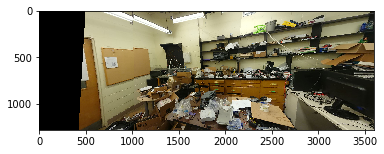

In [81]:
panorama(H12_refined, H23_refined, H34_refined, H45_refined, img1, img2, img3, img4, img5, 'refined')